In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import LogFormatter
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import json
import plategig

PROJECT_PATH = Path('/project/greencenter/Toprak_lab/shared/plategig/projects')
PROJECT_ID = '241011_Adam'

#### Step 1: Read Plate Information

In [2]:
# Read the Excel file into a DataFrame
df_plate_info = pd.read_excel(PROJECT_PATH / PROJECT_ID / 'data' / 'PlateInfo.xlsx', engine='openpyxl')
df_plate_info

Experiment  Plate Well      Strain  Culture  Replicate    Antibiotic  \
0               1      1   A1           P      1.0        1.0  Levofloxacin   
1               1      1   A2           P      1.0        1.0  Levofloxacin   
2               1      1   A3           P      1.0        1.0  Levofloxacin   
3               1      1   A4           P      1.0        1.0  Levofloxacin   
4               1      1   A5           P      1.0        1.0  Levofloxacin   
...           ...    ...  ...         ...      ...        ...           ...   
14587           3      4   H8  Media Only      NaN        NaN           NaN   
14588           3      4   H9  Media Only      NaN        NaN           NaN   
14589           3      4  H10  Media Only      NaN        NaN           NaN   
14590           3      4  H11  Media Only      NaN        NaN           NaN   
14591           3      4  H12  Media Only      NaN        NaN           NaN   

       Dose  
0       8.0  
1       4.0  
2       2.0  
3       1.0  
4       0.5  
...     ...  
14587   NaN  
14588   NaN  
14589   NaN  
14590   NaN  
14591   NaN  

[14592 rows x 8 columns]

In [3]:
def calculate_plate_id(row):
    if row['Experiment'] == 1:
        return row['Plate']
    elif row['Experiment'] == 2:
        return row['Plate'] + 99
    elif row['Experiment'] == 3:
        return row['Plate'] + 148
    else:
        return None  # Handle other experiments if needed

# Step 2: Apply the function to each row in the DataFrame and create the new 'Plate_ID' column
df_plate_info['Plate_ID'] = df_plate_info.apply(calculate_plate_id, axis=1)

# Step 3: Display the updated DataFrame
print(df_plate_info.head())

   Experiment  Plate Well Strain  Culture  Replicate    Antibiotic  Dose  \
0           1      1   A1      P      1.0        1.0  Levofloxacin   8.0   
1           1      1   A2      P      1.0        1.0  Levofloxacin   4.0   
2           1      1   A3      P      1.0        1.0  Levofloxacin   2.0   
3           1      1   A4      P      1.0        1.0  Levofloxacin   1.0   
4           1      1   A5      P      1.0        1.0  Levofloxacin   0.5   

   Plate_ID  
0         1  
1         1  
2         1  
3         1  
4         1  


Collect unique plate IDs

unique_plate_ids, plate_numbers = growthlib.get_unique_plate_ids(df_plate_info)
unique_plate_ids

#### Step 2: Read the raw OD data

In [4]:
df_OD_raw = pd.read_excel(PROJECT_PATH / PROJECT_ID / 'data' /'ODFinal.xlsx')
# drop last nan column, fix to input mistake
df_OD_raw = df_OD_raw.iloc[:,:-1]
df_OD_raw.tail()

Unnamed: 0      1      2      3      4      5      6      7      8  \
1513          D  0.044  0.046  0.045  0.045  0.045  0.044  0.044  0.044   
1514          E  0.467  0.486  0.478  0.456  0.461  0.044  0.045  0.045   
1515          F  0.453  0.453  0.444  0.478  0.489  0.044  0.044  0.045   
1516          G  0.463  0.454  0.457  0.542  0.518  0.044  0.044  0.044   
1517          H  0.046  0.045  0.046  0.046  0.046  0.045  0.044  0.046   

          9     10     11     12   0.046414  
1513  0.044  0.044  0.044  0.045  od600:600  
1514  0.045  0.044  0.046  0.046  od600:600  
1515  0.045  0.044  0.045  0.046  od600:600  
1516  0.045  0.046  0.046  0.046  od600:600  
1517  0.046  0.045  0.046  0.046  od600:600

In [5]:
df = plategig.static.convert_OD_plate_to_long(df_OD_raw, df_plate_info)
df

Plate_ID Well     OD  Row  Column
0             1   A1  0.053    1       1
1             1   A2  0.050    1       2
2             1   A3  0.051    1       3
3             1   A4  0.053    1       4
4             1   A5  0.057    1       5
...         ...  ...    ...  ...     ...
14587       152   H8  0.046    8       8
14588       152   H9  0.046    8       9
14589       152  H10  0.045    8      10
14590       152  H11  0.046    8      11
14591       152  H12  0.046    8      12

[14592 rows x 5 columns]

Calculate median background of all plates to impute plates with missing media-only wells.

In [6]:
df_plate_info[df_plate_info['Strain']=='Media Only']

Experiment  Plate Well      Strain  Culture  Replicate Antibiotic  \
8208            1     33   E1  Media Only      NaN        NaN        NaN   
8209            1     33   E2  Media Only      NaN        NaN        NaN   
8210            1     33   E3  Media Only      NaN        NaN        NaN   
8211            1     33   E4  Media Only      NaN        NaN        NaN   
8212            1     33   E5  Media Only      NaN        NaN        NaN   
...           ...    ...  ...         ...      ...        ...        ...   
14587           3      4   H8  Media Only      NaN        NaN        NaN   
14588           3      4   H9  Media Only      NaN        NaN        NaN   
14589           3      4  H10  Media Only      NaN        NaN        NaN   
14590           3      4  H11  Media Only      NaN        NaN        NaN   
14591           3      4  H12  Media Only      NaN        NaN        NaN   

       Dose  Plate_ID  
8208    NaN        33  
8209    NaN        33  
8210    NaN        33  
8211    NaN        33  
8212    NaN        33  
...     ...       ...  
14587   NaN       152  
14588   NaN       152  
14589   NaN       152  
14590   NaN       152  
14591   NaN       152  

[2808 rows x 9 columns]

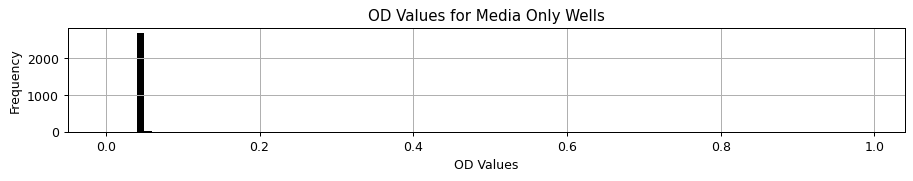

0.045


In [7]:

median_background_all_plates = plategig.static.calc_median_background_all_plates(
    df, df_plate_info, plot=True)
#I had to make these changes because there was a problem with the plate map info, confirm with Adam.
print(median_background_all_plates)

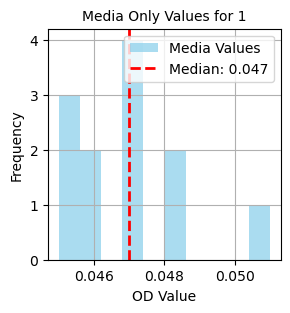

np.float64(0.047)

In [8]:
plategig.static.plot_single_plate_media_only_wells(df, df_plate_info, plate_id=1, column_name='OD')

Apply background correction for all plates

In [9]:
df_bc = df.copy()
df_bc['OD_final'] = df_bc['OD'] - median_background_all_plates

#### Evaluate growth metrics

In [10]:
df_bc

Plate_ID Well     OD  Row  Column  OD_final
0             1   A1  0.053    1       1     0.008
1             1   A2  0.050    1       2     0.005
2             1   A3  0.051    1       3     0.006
3             1   A4  0.053    1       4     0.008
4             1   A5  0.057    1       5     0.012
...         ...  ...    ...  ...     ...       ...
14587       152   H8  0.046    8       8     0.001
14588       152   H9  0.046    8       9     0.001
14589       152  H10  0.045    8      10     0.000
14590       152  H11  0.046    8      11     0.001
14591       152  H12  0.046    8      12     0.001

[14592 rows x 6 columns]

In [11]:
# Prep the analysis dataframe
df_analysis = pd.merge(df_plate_info, df_bc, on=['Plate_ID', 'Well'])
df_analysis = df_analysis[['Experiment','Strain', 'Culture', 'Replicate', 'Antibiotic',
                           'Dose', 'Plate_ID', 'Well', 'Row', 'Column',
                           'OD', 'OD_final']]
# Remove control wells
df_analysis = df_analysis[~df_analysis['Strain'].isin(['Media Only','Cells Only'])]
# Keep group names
df_analysis['Group'] = df_analysis.Strain
# Define each culture of as a separate strain
df_analysis['Strain'] = df_analysis.Strain + df_analysis.Culture.astype(int).astype(str)
df_analysis


Experiment     Strain  Culture  Replicate    Antibiotic      Dose  \
0               1         P1      1.0        1.0  Levofloxacin  8.000000   
1               1         P1      1.0        1.0  Levofloxacin  4.000000   
2               1         P1      1.0        1.0  Levofloxacin  2.000000   
3               1         P1      1.0        1.0  Levofloxacin  1.000000   
4               1         P1      1.0        1.0  Levofloxacin  0.500000   
...           ...        ...      ...        ...           ...       ...   
14542           3  ATEC-C-r1      1.0        3.0      Cefepime  0.062500   
14543           3  ATEC-C-r1      1.0        3.0      Cefepime  0.031250   
14544           3  ATEC-C-r1      1.0        3.0      Cefepime  0.015625   
14545           3  ATEC-C-r1      1.0        3.0      Cefepime  0.007812   
14546           3  ATEC-C-r1      1.0        3.0      Cefepime  0.003906   

       Plate_ID Well  Row  Column     OD  OD_final     Group  
0             1   A1    1       1  0.053     0.008         P  
1             1   A2    1       2  0.050     0.005         P  
2             1   A3    1       3  0.051     0.006         P  
3             1   A4    1       4  0.053     0.008         P  
4             1   A5    1       5  0.057     0.012         P  
...         ...  ...  ...     ...    ...       ...       ...  
14542       152   G1    7       1  0.463     0.418  ATEC-C-r  
14543       152   G2    7       2  0.454     0.409  ATEC-C-r  
14544       152   G3    7       3  0.457     0.412  ATEC-C-r  
14545       152   G4    7       4  0.542     0.497  ATEC-C-r  
14546       152   G5    7       5  0.518     0.473  ATEC-C-r  

[11784 rows x 13 columns]

In [13]:
# TOdo:
# Remove some failed experiments:
# From experiment 1
#   ‘strain’ == ‘PAC’         (not used)
#   ‘strain’ == PCr             (range to small)
#   cultures == PLAC7 & PLAC10        (bad curve)
# From Experiment 2
#    ATEC 1,2,4     (plating error)
#    ATEC-C 3       (plating error)
#    ATEC-C-r        (plating error)
### Groups to remove
    # PAC
    # P
# Define the combinations of 'Experiment' and 'Group' to remove
df_analysis['Experiment'] = df_analysis['Experiment'].astype(str).str.strip()

groups_to_remove = [('1', 'PAC'), ('1', 'PCr'), ('2', 'ATEC-C-R')]

# Remove rows where the 'Experiment' and 'Group' match the combinations in groups_to_remove
df_analysis = df_analysis[~df_analysis[['Experiment', 'Group']].apply(tuple, axis=1).isin(groups_to_remove)]

# Define the combinations of 'Experiment' and 'Strain' to remove
strains_to_remove = [('1', 'PLAC7'), ('1', 'PLAC10'), ('2', 'ATEC1'), ('2', 'ATEC2'), ('2', 'ATEC4'), ('2', 'ATEC-C3')]

# Remove rows where the 'Experiment' and 'Strain' match the combinations in strains_to_remove
df_analysis = df_analysis[~df_analysis[['Experiment', 'Strain']].apply(tuple, axis=1).isin(strains_to_remove)]


In [12]:
# Select subgroups
df_analysis = df_analysis.query("Group.isin(['P','PA','PC','PL'])")
df_analysis

Experiment Strain  Culture  Replicate    Antibiotic      Dose  \
0               1     P1      1.0        1.0  Levofloxacin  8.000000   
1               1     P1      1.0        1.0  Levofloxacin  4.000000   
2               1     P1      1.0        1.0  Levofloxacin  2.000000   
3               1     P1      1.0        1.0  Levofloxacin  1.000000   
4               1     P1      1.0        1.0  Levofloxacin  0.500000   
...           ...    ...      ...        ...           ...       ...   
11940           2     P6      6.0        3.0      Cefepime  0.062500   
11941           2     P6      6.0        3.0      Cefepime  0.031250   
11942           2     P6      6.0        3.0      Cefepime  0.015625   
11943           2     P6      6.0        3.0      Cefepime  0.007812   
11944           2     P6      6.0        3.0      Cefepime  0.003906   

       Plate_ID Well  Row  Column     OD  OD_final Group  
0             1   A1    1       1  0.053     0.008     P  
1             1   A2    1       2  0.050     0.005     P  
2             1   A3    1       3  0.051     0.006     P  
3             1   A4    1       4  0.053     0.008     P  
4             1   A5    1       5  0.057     0.012     P  
...         ...  ...  ...     ...    ...       ...   ...  
11940       133   G1    7       1  0.136     0.091     P  
11941       133   G2    7       2  0.559     0.514     P  
11942       133   G3    7       3  0.477     0.432     P  
11943       133   G4    7       4  0.634     0.589     P  
11944       133   G5    7       5  0.663     0.618     P  

[5058 rows x 13 columns]

In [13]:
### Double check
unique_columns = df_analysis.columns.tolist()

# Print the list of unique columns
print(unique_columns)

#
unique_values = df_analysis['Strain'].unique()

# Print the unique values
print(unique_values)

['Experiment', 'Strain', 'Culture', 'Replicate', 'Antibiotic', 'Dose', 'Plate_ID', 'Well', 'Row', 'Column', 'OD', 'OD_final', 'Group']
['P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'PA1' 'PA2' 'PA3'
 'PA4' 'PA5' 'PA6' 'PA7' 'PA8' 'PA9' 'PA10' 'PC1' 'PC2' 'PC3' 'PC4' 'PC5'
 'PC6' 'PC7' 'PC8' 'PC9' 'PC10' 'PL1' 'PL2' 'PL3' 'PL4' 'PL5' 'PL6' 'PL7'
 'PL8' 'PL9' 'PL10']


In [14]:
antibiotics = df_analysis['Antibiotic'].unique()
antibiotics 

array(['Levofloxacin', 'Amikacin', 'Cefepime'], dtype=object)

In [15]:
df_analysis.query("Antibiotic == 'Levofloxacin' & Strain == 'P1'")

Experiment Strain  Culture  Replicate    Antibiotic      Dose  Plate_ID  \
0              1     P1      1.0        1.0  Levofloxacin  8.000000         1   
1              1     P1      1.0        1.0  Levofloxacin  4.000000         1   
2              1     P1      1.0        1.0  Levofloxacin  2.000000         1   
3              1     P1      1.0        1.0  Levofloxacin  1.000000         1   
4              1     P1      1.0        1.0  Levofloxacin  0.500000         1   
...          ...    ...      ...        ...           ...       ...       ...   
9535           2     P1      1.0        3.0  Levofloxacin  0.062500       100   
9536           2     P1      1.0        3.0  Levofloxacin  0.031250       100   
9537           2     P1      1.0        3.0  Levofloxacin  0.015625       100   
9538           2     P1      1.0        3.0  Levofloxacin  0.007812       100   
9539           2     P1      1.0        3.0  Levofloxacin  0.000000       100   

     Well  Row  Column     OD  OD_final Group  
0      A1    1       1  0.053     0.008     P  
1      A2    1       2  0.050     0.005     P  
2      A3    1       3  0.051     0.006     P  
3      A4    1       4  0.053     0.008     P  
4      A5    1       5  0.057     0.012     P  
...   ...  ...     ...    ...       ...   ...  
9535   D8    4       8  0.061     0.016     P  
9536   D9    4       9  0.125     0.080     P  
9537  D10    4      10  0.441     0.396     P  
9538  D11    4      11  0.541     0.496     P  
9539  D12    4      12  0.599     0.554     P  

[72 rows x 13 columns]

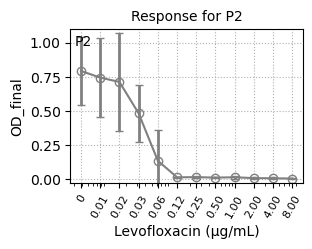

In [28]:

# Adjust the figure size as needed
fig, ax = plt.subplots(figsize=(3, 2))
plategig.static.plot_dose_response_curve_errorbar(df_analysis, 'P2', 'Levofloxacin', strain_colors={'P1':'black'}, ax=ax)

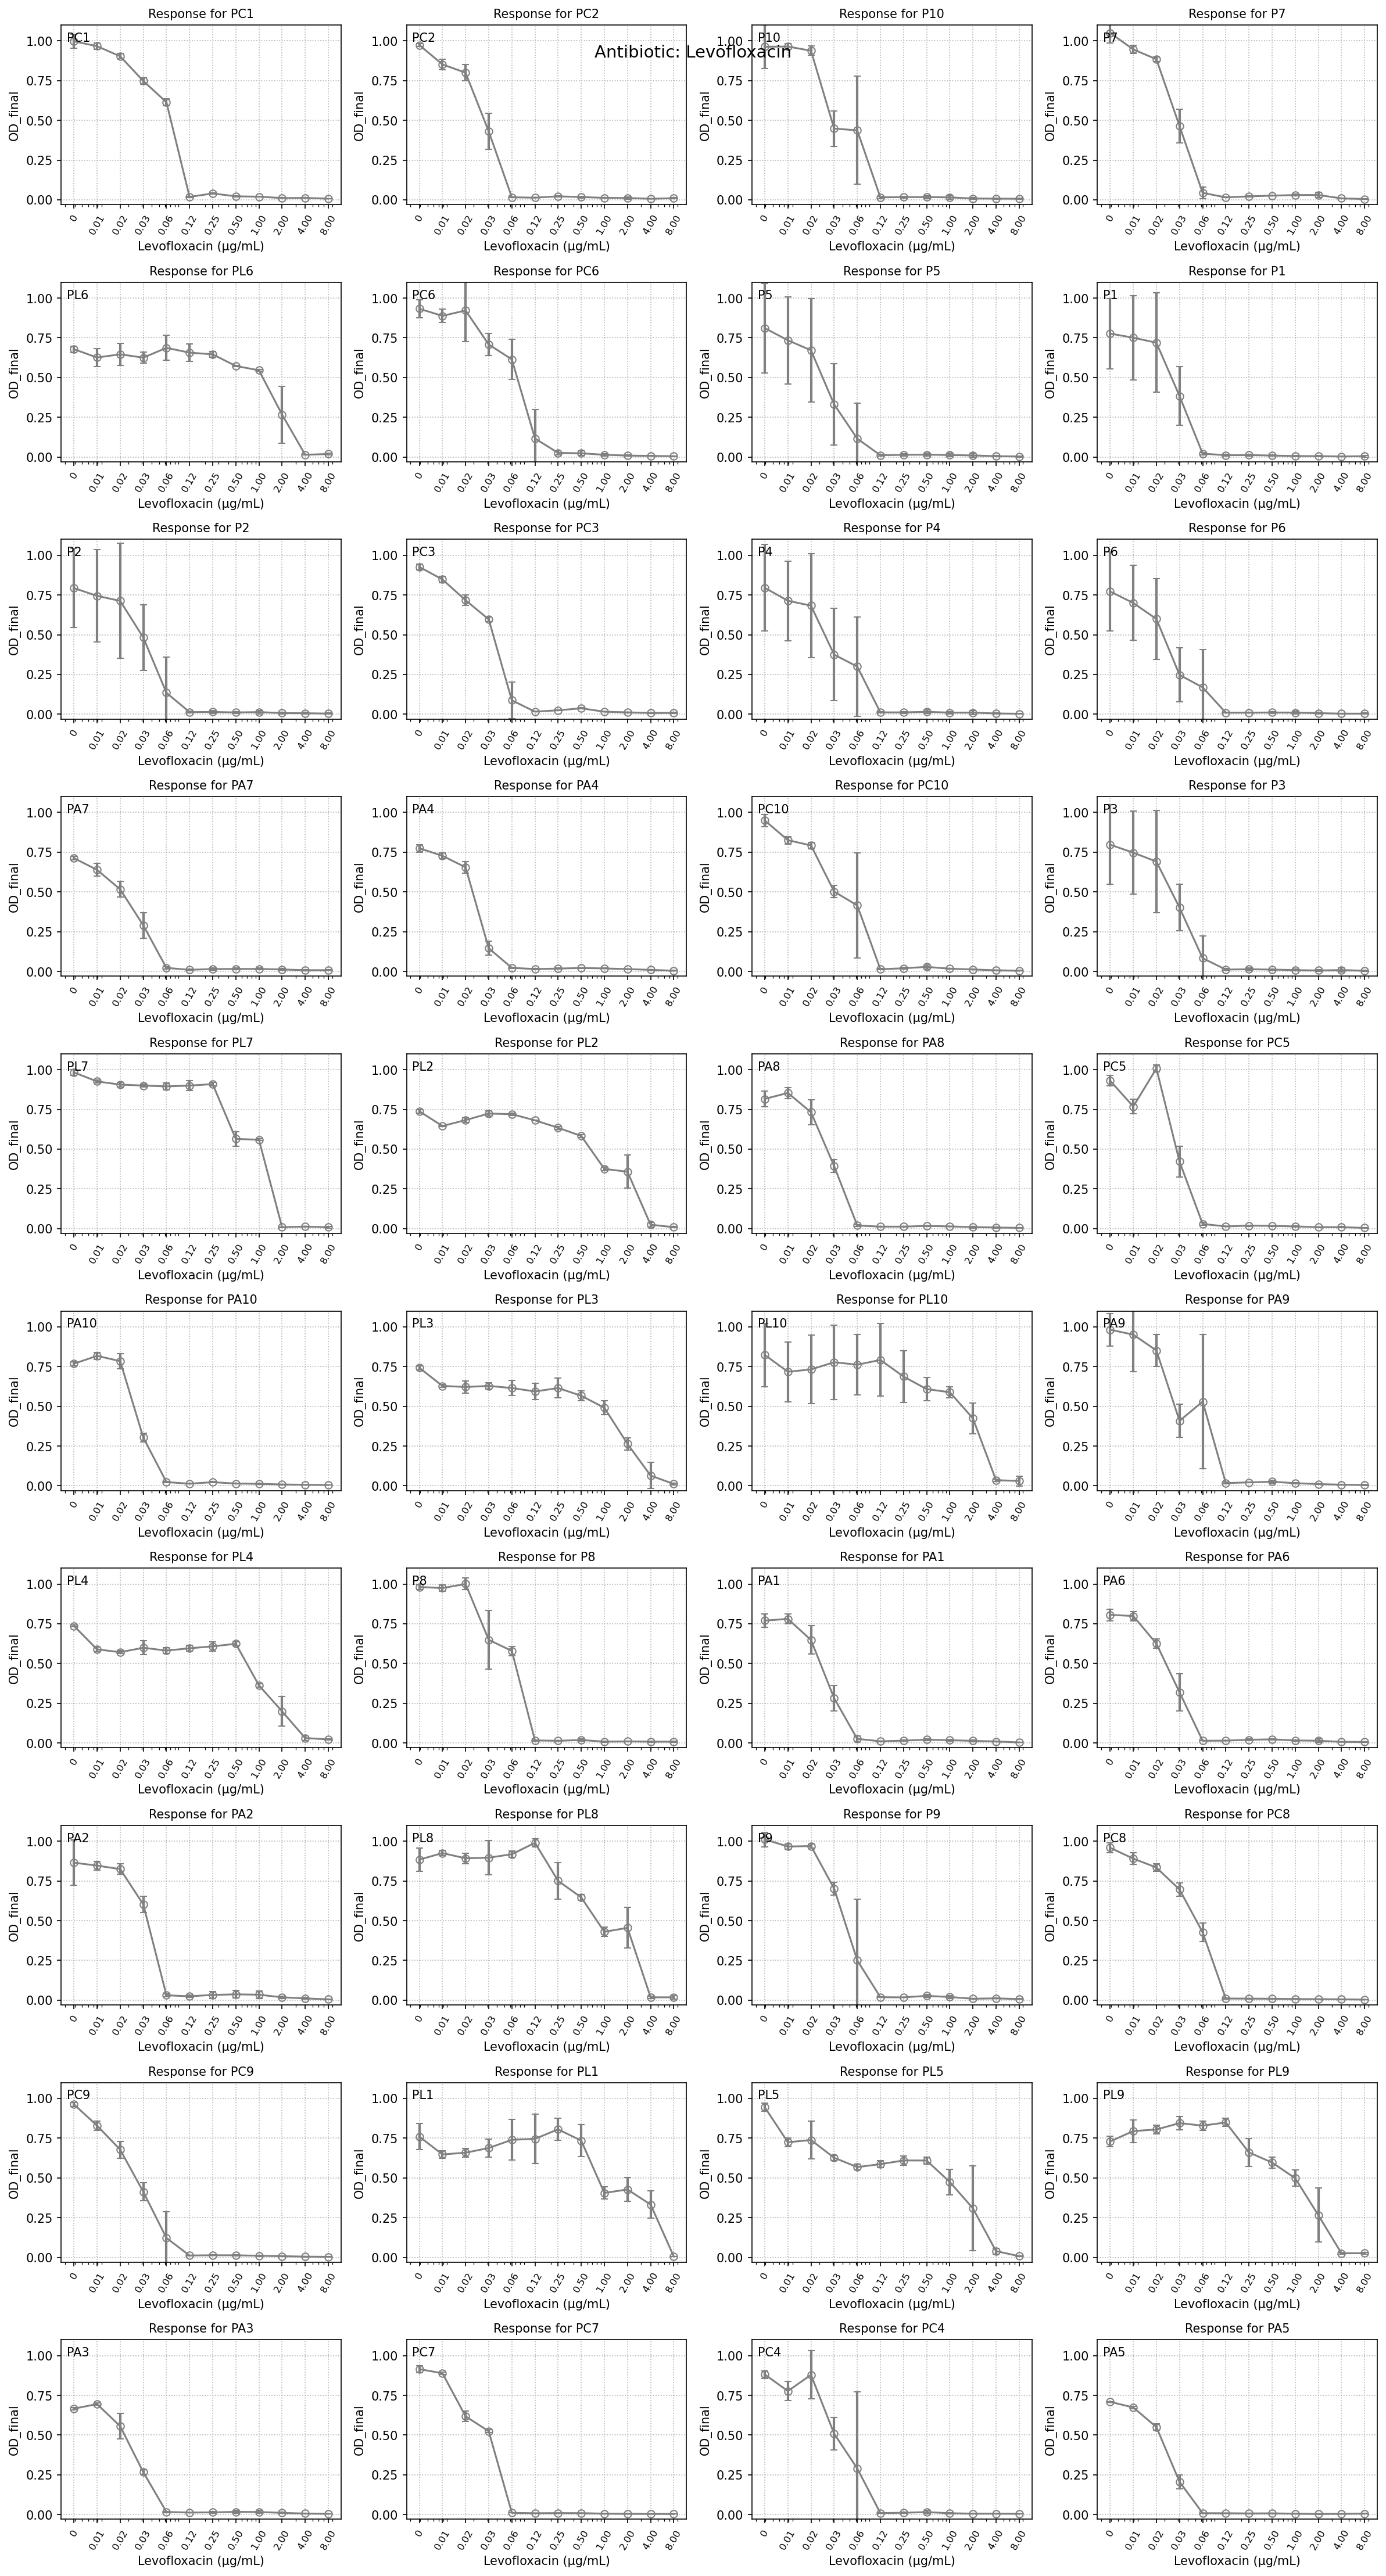

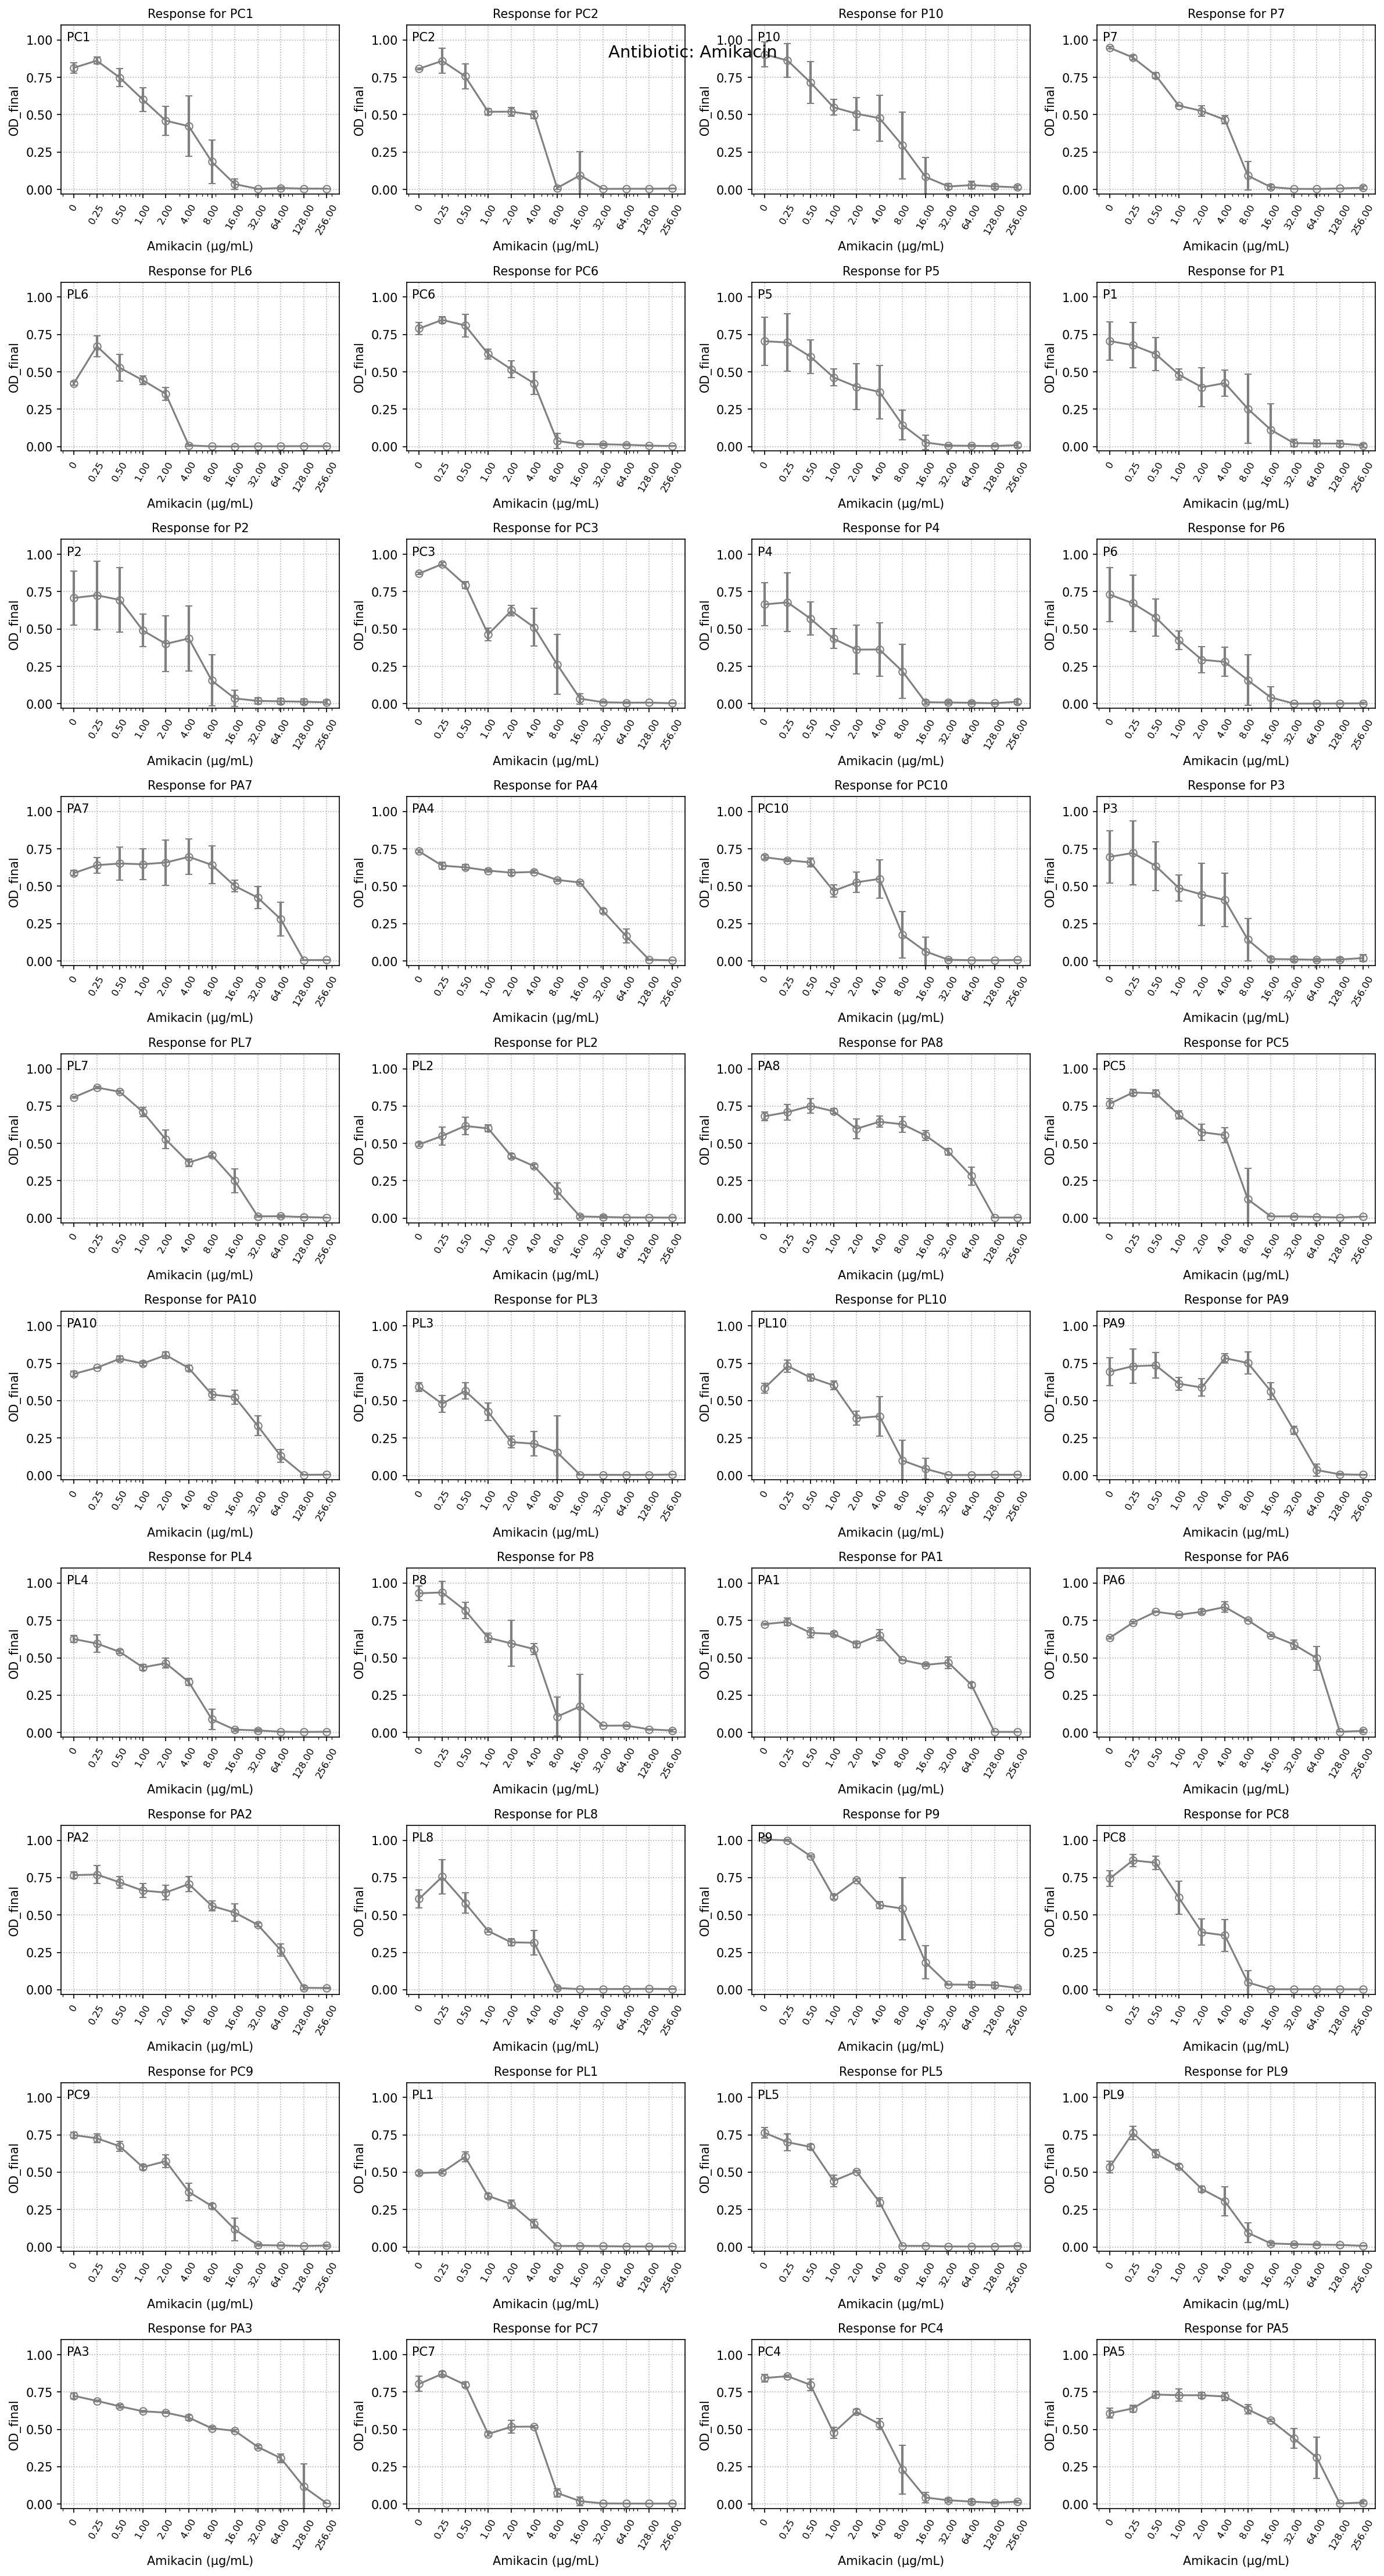

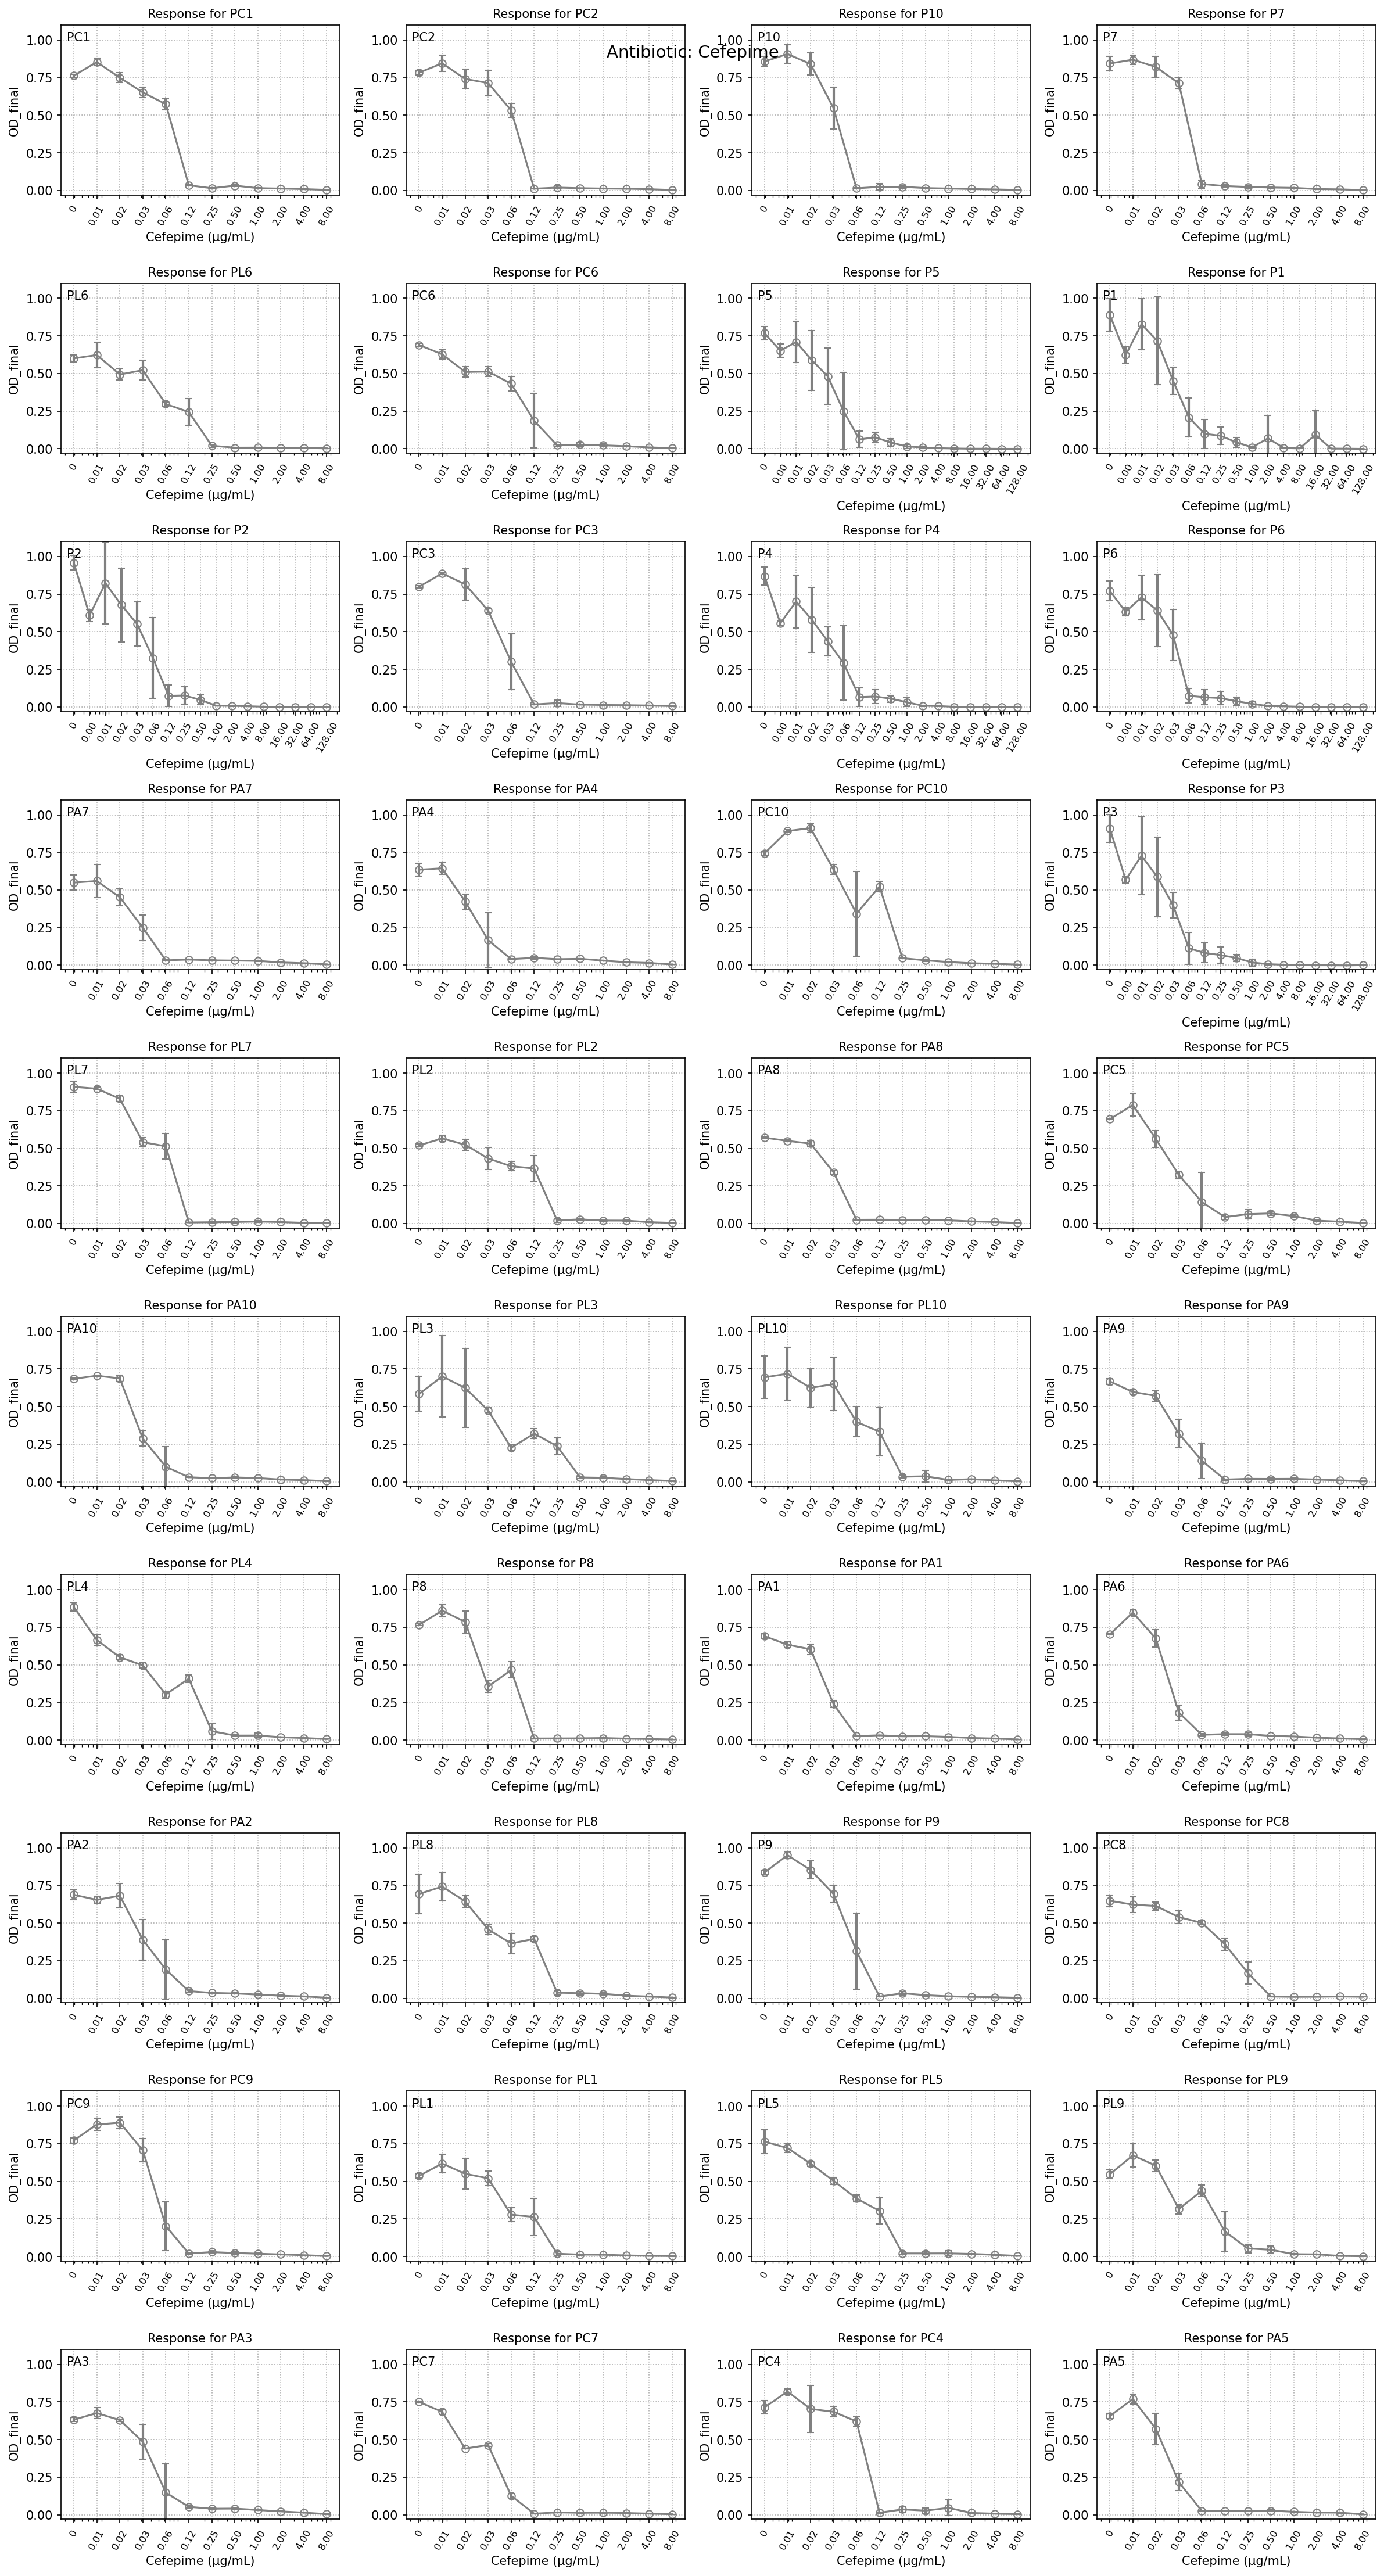

In [19]:
# Plot all dose-response curves in the df_analysis tables (might take too long)
for drug in antibiotics:
    if not pd.isna(drug):
        plategig.static.plot_od_final_for_selected_antibiotic(
            df_analysis,
            plategig.static.plot_dose_response_curve_errorbar,
            drug,
            strain_colors={})

In [20]:
valid_combinations = plategig.static.prep_valid_combinations(
    df_analysis,
    multiplex=['Strain', 'Antibiotic'],
    ic50_threshold=0.5,
    mic_threshold=0.05)
valid_combinations

Strain    Antibiotic
0       P1  Levofloxacin
1       P2  Levofloxacin
2       P3  Levofloxacin
3       P4  Levofloxacin
4       P5  Levofloxacin
..     ...           ...
115    PL6      Cefepime
116    PL7      Cefepime
117    PL8      Cefepime
118    PL9      Cefepime
119   PL10      Cefepime

[120 rows x 2 columns]

In [22]:
# growthlib.static.phenotyper(df_analysis,
#                             valid_combinations,
#                             metric='OD_final',
#                             fit_function=growthlib.four_param_logistic,
#                             strain='P',
#                             antibiotic='Levofloxacin',
#                             replicate=1)

In [21]:
growth_features = plategig.static.apply_phenotyper(df_analysis, valid_combinations)
growth_features = plategig.static.cap_growth_features_within_experiment_range(growth_features)
growth_features

Strain    Antibiotic Status      IC50       MIC  IC50_ci_lower  \
0       P1  Levofloxacin   PASS  0.030756  0.063292       0.022325   
1       P2  Levofloxacin   PASS  0.035086  0.103268       0.024528   
2       P3  Levofloxacin   PASS  0.031816  0.082003       0.024494   
3       P4  Levofloxacin   PASS  0.039581  0.163157       0.024190   
4       P5  Levofloxacin   PASS  0.030621  0.076035       0.021514   
..     ...           ...    ...       ...       ...            ...   
115    PL6      Cefepime   PASS  0.075608  0.428674       0.065569   
116    PL7      Cefepime   PASS  0.051690  0.222172       0.047000   
117    PL8      Cefepime   PASS  0.081786  0.739518       0.073155   
118    PL9      Cefepime   PASS  0.072543  0.536370       0.061590   
119   PL10      Cefepime   PASS  0.079538  0.562412       0.058757   

     IC50_ci_upper  max_growth  hill_coeff  ic50_threshold  mic_threshold  \
0         0.034540      0.7805    4.079989         0.39025       0.039025   
1         0.045530      0.8055    2.727527         0.40275       0.040275   
2         0.037378      0.7755    3.109950         0.38775       0.038775   
3         0.062456      0.7405    2.078856         0.37025       0.037025   
4         0.042966      0.7310    3.237371         0.36550       0.036550   
..             ...         ...         ...             ...            ...   
115       0.085790      0.5925    1.696948         0.29625       0.029625   
116       0.056322      0.8920    2.019253         0.44600       0.044600   
117       0.091392      0.6910    1.337229         0.34550       0.034550   
118       0.089299      0.6010    1.471745         0.30050       0.030050   
119       0.103073      0.7445    1.505338         0.37225       0.037225   

                                                 x_fit  \
0    [0.00390625, 0.004248626161543717, 0.004621011...   
1    [0.00390625, 0.004248626161543717, 0.004621011...   
2    [0.00390625, 0.004248626161543717, 0.004621011...   
3    [0.00390625, 0.004248626161543717, 0.004621011...   
4    [0.00390625, 0.004248626161543717, 0.004621011...   
..                                                 ...   
115  [0.00390625, 0.004248626161543717, 0.004621011...   
116  [0.00390625, 0.004248626161543717, 0.004621011...   
117  [0.00390625, 0.004248626161543717, 0.004621011...   
118  [0.00390625, 0.004248626161543717, 0.004621011...   
119  [0.00390625, 0.004248626161543717, 0.004621011...   

                                                 y_fit  \
0    [0.7803278448251768, 0.7802574766670972, 0.780...   
1    [0.8034833754668613, 0.8029656392742125, 0.802...   
2    [0.7743620276035422, 0.7740228696495413, 0.773...   
3    [0.7345397846119063, 0.7334132084270468, 0.732...   
4    [0.7300703185192482, 0.7297802008908276, 0.729...   
..                                                 ...   
115  [0.5886433595196197, 0.5880568062806407, 0.587...   
116  [0.8871792064027013, 0.8862935731357421, 0.885...   
117  [0.6793658912126269, 0.6780085381681993, 0.676...   
118  [0.5929533174791671, 0.591910207806235, 0.5907...   
119  [0.736610880121612, 0.7355600300471821, 0.7343...   

                                        ic50_bootstrap  insufficient_drug  
0    [0.03117134975862426, 0.028746942483116086, 0....              False  
1    [0.033733859846869434, 0.0281092182415157, 0.0...              False  
2    [0.03183848027753788, 0.033517701901134754, 0....              False  
3    [0.04171811672211747, 0.04267832561983741, 0.0...              False  
4    [0.031818082177287176, 0.024972003878340945, 0...              False  
..                                                 ...                ...  
115  [0.07174431996884847, 0.06642666505391319, 0.0...              False  
116  [0.05136006395906036, 0.05210284523481012, 0.0...              False  
117  [0.08589478321317447, 0.07968072509769715, 0.0...              False  
118  [0.06825749562613034, 0.07087413544091535, 0.0...              False  
119  [0.

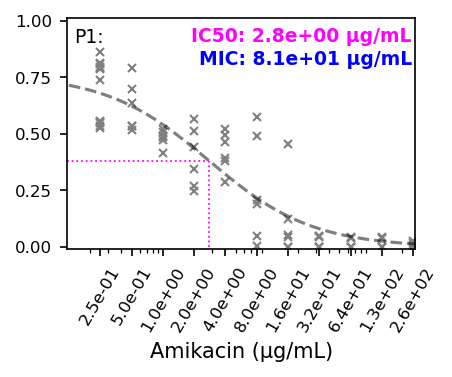

In [23]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
plategig.static.plot_dose_response_curve_fit(df_analysis,
                                              strain='P1',
                                              antibiotic='Amikacin',
                                              growth_features=growth_features,
                                              strain_colors={},
                                              ax=ax)
fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures/PL3-1 IC50 fit.png', dpi=300, bbox_inches='tight')

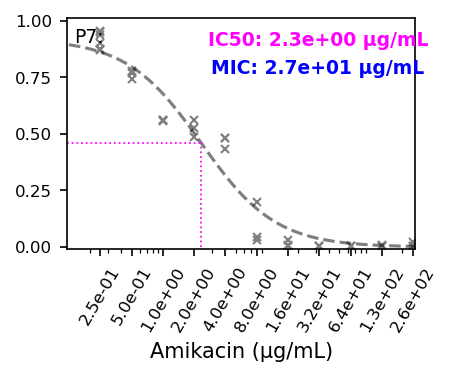

In [34]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
plategig.static.plot_dose_response_curve_fit(df_analysis,
                                              strain='P7',
                                              antibiotic='Amikacin',
                                              growth_features=growth_features,
                                              strain_colors={},
                                              ax=ax)

In [24]:
strains = list(set(df_analysis['Strain'].str.lower()) - set(['media only', 'cells only', np.nan]))
print(strains)

['pl1', 'pc3', 'pa4', 'pa6', 'pc8', 'p1', 'p4', 'pl5', 'pa3', 'pc7', 'p9', 'pl6', 'pl3', 'pa10', 'pa2', 'pa1', 'p3', 'pc1', 'pc2', 'pc10', 'pl4', 'p6', 'pa9', 'pl2', 'pc9', 'p5', 'pa8', 'p8', 'p2', 'pa7', 'pl9', 'pa5', 'p7', 'pc4', 'pc6', 'pl10', 'pc5', 'p10', 'pl8', 'pl7']


In [25]:
antibiotics = list(set(df_analysis['Antibiotic'].str.lower()) - set(['media only', 'cells only', np.nan]))
antibiotics

['amikacin', 'cefepime', 'levofloxacin']

In [26]:
strain_colors = {strain:color for strain, color in zip(strains, sns.color_palette('muted')[:len(strains)])}


In [27]:
num_drugs = growth_features['Antibiotic'].nunique()
num_experiments = growth_features.shape[0]
num_cols = 6
num_rows = num_experiments//num_cols + (num_experiments % num_cols > 0)
# num_cols = num_experiments//num_drugs
# fig, axes = plt.subplots(num_experiments//num_replicates, num_replicates,
#                        figsize=(num_replicates*3, num_experiments*2), dpi=90)
fig, axes = plt.subplots(num_rows, num_cols,
                       figsize=(num_cols*3, num_rows*2), dpi=300)

for ix, row in growth_features.iterrows():
    plategig.static.plot_dose_response_curve_fit(df_analysis,
                                                growth_features=growth_features,
                                                strain_colors=strain_colors,
                                                strain=row['Strain'],
                                                antibiotic=row['Antibiotic'],
                                                ax=axes.flat[ix])
    
    if row['Status'] == 'FAIL':
        axes.flat[ix].text(0.5, 0.5, f'FAIL', color='red', fontsize=12, fontweight='bold',
                        ha='center', va='center', transform=axes.flat[ix].transAxes)
        # gray out the entire axes
        axes.flat[ix].set_facecolor('lightgray')
    if ix % num_cols != 0:
        axes.flat[ix].set_yticklabels([])
# Hide the rest of the axes
for ix in range(num_experiments, num_cols*num_rows):
    axes.flat[ix].axis('off')
    
fig.tight_layout()
# set empty space between subplots
fig.subplots_adjust(wspace=0.05)
fig.savefig(PROJECT_PATH / PROJECT_ID / 'figures' / f'IC50 fits.png', dpi=300, bbox_inches='tight')

In [31]:
#### Graphes the IC50 values for each with a confindence interval
    ### looks like it pulls growth_features

final_chart = alt.vconcat()
for drug in sorted(growth_features['Antibiotic'].unique()):
    select_cols = ['Strain','Antibiotic','Status','IC50','IC50_ci_lower','IC50_ci_upper', 'insufficient_drug']
    filtered_growth_features = growth_features[select_cols]
    filtered_growth_features = filtered_growth_features.query(f'Antibiotic == "{drug}" & Status == "PASS"')
    filtered_growth_features['StrainGroup'] = filtered_growth_features['Strain'].str.extract(r'(\D+)')

    base = alt.Chart(filtered_growth_features).encode(
        x='Strain',
    ).properties(width=700, height=300)

    ic50 = base.encode(
        y=alt.Y('IC50:Q', scale=alt.Scale(type="log")),
        color=alt.Color("StrainGroup:N")
    ).mark_point(filled=True, size=200)

    error_bars = base.mark_errorbar(ticks=True, size=10, thickness=2).encode(
        alt.Y("IC50_ci_lower:Q", scale=alt.Scale(type="log")).title('IC50'),
        alt.Y2("IC50_ci_upper:Q"),
        color='StrainGroup'
    )

    # Create a dagger symbol on the bars with insufficient_drug flag is true
    dagger = base.mark_text(align='center', baseline='middle', fontSize=14, color='black', fontWeight='bold', dy=-20, dx=0).encode(
        y=alt.Y('IC50'),
        text=alt.condition(
            alt.datum.insufficient_drug, if_true=alt.value("‡"), if_false=alt.value("")
            )
    )

    layered_chart = alt.layer(ic50, error_bars, dagger).properties(title=drug)
    final_chart &= layered_chart

final_chart = final_chart.resolve_scale(y='independent', x='independent').configure_axis(
    labelFontSize=18,
    titleFontSize=18,
).configure_title(
    fontSize=18,
    anchor='middle',
).configure_legend(
    titleFontSize=18,
    labelFontSize=18,
    symbolLimit=50,
)

final_chart = final_chart.configure_title(anchor='middle')
final_chart.save(PROJECT_PATH / PROJECT_ID / 'figures' / f'IC50 combined.png', scale_factor=2)
final_chart.show()

alt.VConcatChart(...)

In [32]:
(
growth_features[['Antibiotic','Strain','Status','IC50','MIC','IC50_ci_lower','IC50_ci_upper', 'max_growth', 'hill_coeff']]
.to_csv(PROJECT_PATH / PROJECT_ID / 'figures' / f'IC50 estimations.csv',
          index=False)
)